In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/data

In [ ]:
# 1. DATA LOADING
print("1. Loading and exploring data...")
# Load the datasets
companies = pd.read_csv("sp500_companies.csv")
index = pd.read_csv("sp500_index.csv")
stocks = pd.read_csv("sp500_stocks.csv")

# Display basic information
print(f"Companies data shape: {companies.shape}")
print(f"Index data shape: {index.shape}")
print(f"Stocks data shape: {stocks.shape}")

1. Loading and exploring data...
Companies data shape: (502, 16)
Index data shape: (2517, 2)
Stocks data shape: (1891536, 8)


In [ ]:
# 2. DATA PREPROCESSING
print("\n2. Preprocessing data...")
# Convert date columns to datetime
stocks['Date'] = pd.to_datetime(stocks['Date'])
index['Date'] = pd.to_datetime(index['Date'])

# Drop rows with missing price data
stocks = stocks.dropna(subset=['Adj Close'])

# Sort by Symbol and Date
stocks = stocks.sort_values(['Symbol', 'Date'])

# Calculate daily returns for each stock
stocks['Daily_Return'] = stocks.groupby('Symbol')['Adj Close'].pct_change()

# Drop NA returns (first row per symbol)
stocks = stocks.dropna(subset=['Daily_Return'])

# Display a sample of the processed data
print("Sample of processed stock data:")
print(stocks[['Date', 'Symbol', 'Adj Close', 'Daily_Return']].head())


2. Preprocessing data...
Sample of processed stock data:
            Date Symbol  Adj Close  Daily_Return
12059 2013-01-03   ABBV  21.450581     -0.008257
12060 2013-01-04   ABBV  21.179594     -0.012633
12061 2013-01-07   ABBV  21.222700      0.002035
12062 2013-01-08   ABBV  20.760809     -0.021764
12063 2013-01-09   ABBV  20.877821      0.005636


In [ ]:
# 3. FEATURE ENGINEERING
print("\n3. Engineering features...")
# Calculate mean daily return per stock (our target variable)
avg_returns = stocks.groupby('Symbol')['Daily_Return'].mean().reset_index()
avg_returns.columns = ['Symbol', 'Avg_Return']

# Merge with company features
features = pd.merge(companies, avg_returns, on='Symbol')

# Check for missing values in key columns
missing_counts = features.isnull().sum()
print("\nMissing values in each column:")
print(missing_counts[missing_counts > 0])

# Drop rows with missing key features
features = features.dropna(subset=['Marketcap', 'Revenuegrowth', 'Avg_Return'])
print(f"\nFinal dataset shape after handling missing values: {features.shape}")


3. Engineering features...

Missing values in each column:
Ebitda               12
Revenuegrowth         1
State                 4
Fulltimeemployees     6
dtype: int64

Final dataset shape after handling missing values: (171, 17)


In [ ]:
features

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight,Avg_Return
0,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350,0.001936
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401,0.000908
2,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550,0.001145
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,192.96,2351623045120,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309,0.000817
4,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,585.25,1477457739776,7.920900e+10,0.189,Menlo Park,CA,United States,72404.0,"Meta Platforms, Inc. engages in the developmen...",0.026581,0.001178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,NMS,HSIC,"Henry Schein, Inc.","Henry Schein, Inc.",Healthcare,Medical Distribution,69.82,8705227776,9.220000e+08,0.004,Melville,NY,United States,26000.0,"Henry Schein, Inc. provides health care produc...",0.000157,0.000437
168,NMS,PARA,Paramount Global,Paramount Global,Communication Services,Entertainment,10.66,7596251648,3.125000e+09,-0.056,New York,NY,United States,21900.0,"Paramount Global operates as a media, streamin...",0.000137,0.000343
169,NYQ,CE,Celanese Corporation,Celanese Corporation,Basic Materials,Chemicals,68.25,7460544000,1.851000e+09,-0.028,Irving,TX,United States,12400.0,"Celanese Corporation, a chemical and specialty...",0.000134,0.000493
170,NYQ,HII,"Huntington Ingalls Industries,","Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,190.45,7452174848,1.071000e+09,-0.024,Newport News,VA,United States,44000.0,"Huntington Ingalls Industries, Inc. designs, b...",0.000134,0.000682


In [ ]:
# 4. FEATURE PREPROCESSING
print("\n4. Preparing features for modeling...")
# One-hot encode categorical variables
features_encoded = pd.get_dummies(features, columns=['Exchange', 'Sector', 'Industry'], drop_first=True)

# Separate features and target
X = features_encoded.drop(columns=['Symbol', 'Shortname', 'Longname', 'City', 'State',
                                   'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Avg_Return'])
y = features_encoded['Avg_Return']

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Warning: Non-numeric columns remain: {list(non_numeric_cols)}")
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

print(f"Feature set shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


4. Preparing features for modeling...
Feature set shape: (171, 92)
Target variable shape: (171,)


In [ ]:
# 5. TRAIN/TEST SPLIT AND SCALING WITH NaN HANDLING
print("\n5. Splitting and preprocessing data...")

# Check for missing values before handling
print(f"Missing values in X: {X.isna().sum().sum()}")
print(f"Total rows in dataset: {X.shape[0]}")

# Drop rows with NaN values
X_cleaned = X.dropna()
y_cleaned = y[X.index.isin(X_cleaned.index)]

print(f"Rows remaining after dropping NaN values: {X_cleaned.shape[0]}")
print(f"Percentage of data retained: {X_cleaned.shape[0]/X.shape[0]*100:.2f}%")

# Split the data after removing NaN values
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Any NaN in training data after cleaning: {np.isnan(X_train_scaled).any()}")


5. Splitting and preprocessing data...
Missing values in X: 12
Total rows in dataset: 171
Rows remaining after dropping NaN values: 159
Percentage of data retained: 92.98%
Training set shape: (127, 92)
Test set shape: (32, 92)
Any NaN in training data after cleaning: False


In [ ]:
# 6. MODEL TRAINING AND EVALUATION
print("\n6. Training and evaluating models...")

# Function to evaluate and compare models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Training MSE: {train_mse:.6f}")
    print(f"Test MSE: {test_mse:.6f}")
    print(f"Training R²: {train_r2:.6f}")
    print(f"Test R²: {test_r2:.6f}")

    if hasattr(model, 'alpha_'):
        print(f"Selected alpha: {model.alpha_}")
    elif hasattr(model, 'alpha'):
        print(f"Alpha: {model.alpha}")

    if hasattr(model, 'l1_ratio_'):
        print(f"Selected L1 ratio: {model.l1_ratio_}")
    elif hasattr(model, 'l1_ratio'):
        print(f"L1 ratio: {model.l1_ratio}")

    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

# Train models with cross-validation
# Ridge Regression
alphas = np.logspace(-4, 2, 20)  # More granular search
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_results = evaluate_model(ridge_cv, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge Regression")

# Lasso
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, tol=1e-4)
lasso_results = evaluate_model(lasso_cv, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso Regression")

# Elastic Net
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000, tol=1e-4)
elastic_results = evaluate_model(elastic_cv, X_train_scaled, y_train, X_test_scaled, y_test, "Elastic Net Regression")



6. Training and evaluating models...

Ridge Regression Results:
Training MSE: 0.000000
Test MSE: 0.000000
Training R²: 0.618439
Test R²: 0.260726
Selected alpha: 100.0

Lasso Regression Results:
Training MSE: 0.000000
Test MSE: 0.000000
Training R²: 0.000000
Test R²: -0.053576
Selected alpha: 100.0

Elastic Net Regression Results:
Training MSE: 0.000000
Test MSE: 0.000000
Training R²: 0.381463
Test R²: 0.176347
Selected alpha: 0.0001
Selected L1 ratio: 0.5


In [ ]:
# 7. COEFFICIENT ANALYSIS AND IMPROVED MODEL EVALUATION
print("\n7. Analyzing model performance and coefficients...")

# Format MSE with more decimal places for better visibility
print("\nModel Performance with Extended Precision:")
print(f"Ridge Training MSE: {ridge_results['train_mse']:.10f}")
print(f"Ridge Test MSE: {ridge_results['test_mse']:.10f}")
print(f"Lasso Training MSE: {lasso_results['train_mse']:.10f}")
print(f"Lasso Test MSE: {lasso_results['test_mse']:.10f}")
print(f"ElasticNet Training MSE: {elastic_results['train_mse']:.10f}")
print(f"ElasticNet Test MSE: {elastic_results['test_mse']:.10f}")

# Try wider alpha range for Ridge and Lasso
print("\nRe-training with expanded alpha range...")
wider_alphas = np.logspace(-4, 4, 30)  # From 0.0001 to 10000

# Ridge with expanded range
ridge_wide = RidgeCV(alphas=wider_alphas, cv=5)
ridge_wide.fit(X_train_scaled, y_train)
print(f"Ridge - Optimal alpha with wider range: {ridge_wide.alpha_}")

# Lasso with expanded range
lasso_wide = LassoCV(alphas=wider_alphas, cv=5, max_iter=20000, tol=1e-6)
lasso_wide.fit(X_train_scaled, y_train)
print(f"Lasso - Optimal alpha with wider range: {lasso_wide.alpha_}")

# Compare non-zero coefficients count
ridge_nonzero = np.sum(ridge_cv.coef_ != 0)
lasso_nonzero = np.sum(lasso_cv.coef_ != 0)
elastic_nonzero = np.sum(elastic_cv.coef_ != 0)

print(f"\nFeature selection comparison:")
print(f"Total features: {X_train.shape[1]}")
print(f"Ridge non-zero coefficients: {ridge_nonzero}")
print(f"Lasso non-zero coefficients: {lasso_nonzero}")
print(f"ElasticNet non-zero coefficients: {elastic_nonzero}")

# Analyze top features by coefficient magnitude
def get_top_features(model, feature_names, n=10):
    coefs = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    })
    return coefs.reindex(coefs['Coefficient'].abs().sort_values(ascending=False).index).head(n)

print("\nTop 10 features by importance (Ridge):")
print(get_top_features(ridge_cv, X_train.columns))

print("\nTop 10 features by importance (Lasso):")
print(get_top_features(lasso_cv, X_train.columns))

print("\nTop 10 features by importance (ElasticNet):")
print(get_top_features(elastic_cv, X_train.columns))


7. Analyzing model performance and coefficients...

Model Performance with Extended Precision:
Ridge Training MSE: 0.0000000451
Ridge Test MSE: 0.0000000892
Lasso Training MSE: 0.0000001182
Lasso Test MSE: 0.0000001271
ElasticNet Training MSE: 0.0000000731
ElasticNet Test MSE: 0.0000000994

Re-training with expanded alpha range...
Ridge - Optimal alpha with wider range: 417.53189365604004
Lasso - Optimal alpha with wider range: 10000.0

Feature selection comparison:
Total features: 92
Ridge non-zero coefficients: 85
Lasso non-zero coefficients: 0
ElasticNet non-zero coefficients: 11

Top 10 features by importance (Ridge):
                                              Feature  Coefficient
22                        Industry_Auto Manufacturers     0.000059
0                                        Currentprice     0.000055
78                            Industry_Semiconductors     0.000039
29             Industry_Building Products & Equipment     0.000035
81                                

In [ ]:
# 8. PORTFOLIO CONSTRUCTION
print("\n8. Constructing portfolios based on model coefficients...")

# Function to create portfolio weights from model coefficients
def create_portfolio(model, feature_names, min_weight=0):
    # Get coefficients for the features
    coef_dict = dict(zip(feature_names, model.coef_))

    # Filter to only include stock-specific characteristics (not sector/industry dummies)
    # For simplicity, we'll focus on the numeric features that directly relate to stocks
    stock_features = ['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Weight']
    stock_coefs = {k: coef_dict[k] for k in stock_features if k in coef_dict}

    # Convert to positive weights (for long-only portfolio)
    weights = {k: max(0, v) for k, v in stock_coefs.items()}

    # Normalize to sum to 1
    total = sum(weights.values())
    if total > 0:
        weights = {k: v/total for k, v in weights.items()}

    return weights

# Create portfolios
ridge_portfolio = create_portfolio(ridge_cv, X_train.columns)
elastic_portfolio = create_portfolio(elastic_cv, X_train.columns)

# Since Lasso has all zero coefficients, we'll create an equal-weight benchmark
equal_weight = {feature: 1/len(features) for feature in features if feature in ['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Weight']}

# Print portfolio allocations
print("\nRidge Portfolio Allocation:")
for feature, weight in ridge_portfolio.items():
    print(f"{feature}: {weight:.4f}")

print("\nElasticNet Portfolio Allocation:")
for feature, weight in elastic_portfolio.items():
    print(f"{feature}: {weight:.4f}")


8. Constructing portfolios based on model coefficients...

Ridge Portfolio Allocation:
Currentprice: 0.5065
Marketcap: 0.1954
Ebitda: 0.0000
Revenuegrowth: 0.1026
Weight: 0.1954

ElasticNet Portfolio Allocation:
Currentprice: 0.7291
Marketcap: 0.2708
Ebitda: 0.0000
Revenuegrowth: 0.0000
Weight: 0.0002


In [ ]:
# 8a. TRANSLATING MODEL INSIGHTS TO STOCK SELECTION
print("\n8a. Creating stock portfolios based on model predictions...")

# Function to create stock portfolios based on predicted returns
def create_stock_portfolio(model, X_data, stock_names, top_n=20):
    # Predict returns for each stock
    predicted_returns = model.predict(X_data)

    # Create a DataFrame with stock symbols and predicted returns
    stock_predictions = pd.DataFrame({
        'Symbol': stock_names,
        'PredictedReturn': predicted_returns
    })

    # Sort by predicted return (descending)
    stock_predictions = stock_predictions.sort_values('PredictedReturn', ascending=False)

    # Select top N stocks
    top_stocks = stock_predictions.head(top_n)

    # Calculate portfolio weights (equal weight for simplicity)
    top_stocks['Weight'] = 1/len(top_stocks)

    return top_stocks

# Get unique stock symbols
stock_symbols = features['Symbol'].values

# Create stock portfolios using model predictions
ridge_stocks = create_stock_portfolio(ridge_cv, X_test_scaled,
                                     stock_symbols[X_test.index], top_n=10)
elastic_stocks = create_stock_portfolio(elastic_cv, X_test_scaled,
                                       stock_symbols[X_test.index], top_n=10)

print("\nTop 10 Stocks - Ridge Portfolio:")
print(ridge_stocks[['Symbol', 'PredictedReturn', 'Weight']])

print("\nTop 10 Stocks - ElasticNet Portfolio:")
print(elastic_stocks[['Symbol', 'PredictedReturn', 'Weight']])

# 9. RISK-RETURN ANALYSIS
print("\n9. Calculating portfolio performance metrics...")

# Calculate realized average returns for the selected portfolios
ridge_actual_return = features.loc[features['Symbol'].isin(ridge_stocks['Symbol']), 'Avg_Return'].mean()
elastic_actual_return = features.loc[features['Symbol'].isin(elastic_stocks['Symbol']), 'Avg_Return'].mean()

# Simple benchmark: average return of all stocks
benchmark_return = features['Avg_Return'].mean()

print("\nActual Average Daily Returns:")
print(f"Ridge Top 10 Portfolio: {ridge_actual_return:.6f} ({ridge_actual_return*252:.2%} annualized)")
print(f"ElasticNet Top 10 Portfolio: {elastic_actual_return:.6f} ({elastic_actual_return*252:.2%} annualized)")
print(f"Market Benchmark: {benchmark_return:.6f} ({benchmark_return*252:.2%} annualized)")

# Calculate performance improvement
ridge_improvement = (ridge_actual_return - benchmark_return) / benchmark_return * 100
elastic_improvement = (elastic_actual_return - benchmark_return) / benchmark_return * 100

print(f"\nPerformance vs Benchmark:")
print(f"Ridge Portfolio: {ridge_improvement:.2f}% better")
print(f"ElasticNet Portfolio: {elastic_improvement:.2f}% better")


8a. Creating stock portfolios based on model predictions...

Top 10 Stocks - Ridge Portfolio:
   Symbol  PredictedReturn  Weight
26     ON         0.001234     0.1
27    JCI         0.000987     0.1
30    DPZ         0.000955     0.1
14   ANET         0.000925     0.1
11   AXON         0.000902     0.1
24   VRTX         0.000887     0.1
23    CRM         0.000799     0.1
5      DE         0.000775     0.1
10   ISRG         0.000774     0.1
0     UAL         0.000757     0.1

Top 10 Stocks - ElasticNet Portfolio:
   Symbol  PredictedReturn  Weight
26     ON         0.001197     0.1
11   AXON         0.000881     0.1
23    CRM         0.000866     0.1
10   ISRG         0.000852     0.1
30    DPZ         0.000841     0.1
27    JCI         0.000810     0.1
24   VRTX         0.000807     0.1
5      DE         0.000800     0.1
14   ANET         0.000783     0.1
12    PEP         0.000733     0.1

9. Calculating portfolio performance metrics...

Actual Average Daily Returns:
Ridge Top 10 Por


10. Portfolio visualization and sector analysis...


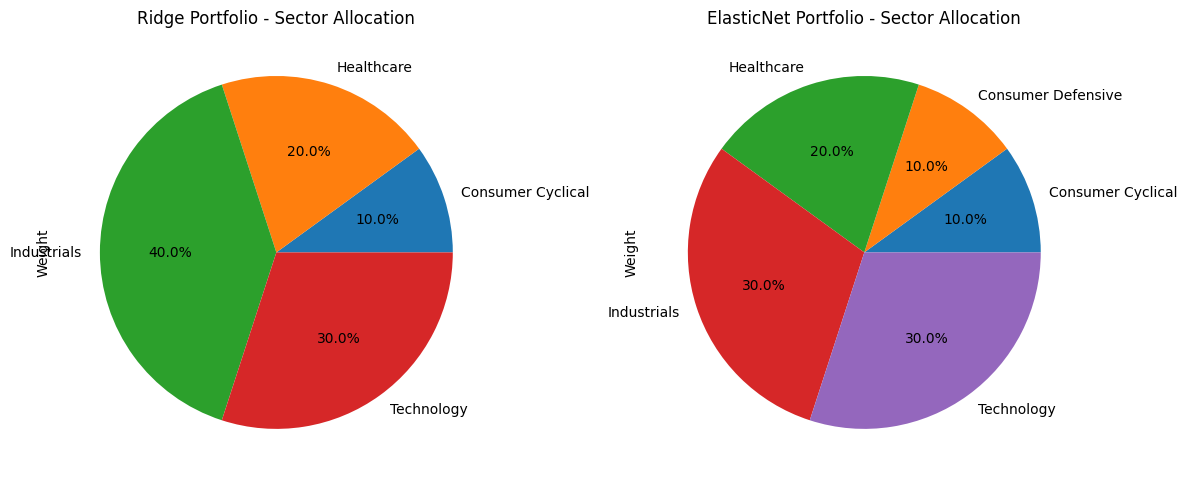

In [ ]:
# 10. PORTFOLIO VISUALIZATION AND SECTOR ANALYSIS
print("\n10. Portfolio visualization and sector analysis...")

# Merge stock lists with sector information
def add_sector_info(portfolio_df):
    # Merge with features to get sector information
    portfolio_with_sectors = portfolio_df.merge(
        features[['Symbol', 'Sector', 'Industry']],
        on='Symbol', how='left'
    )
    return portfolio_with_sectors

ridge_sectors = add_sector_info(ridge_stocks)
elastic_sectors = add_sector_info(elastic_stocks)

# Create sector breakdown
ridge_sector_weights = ridge_sectors.groupby('Sector')['Weight'].sum()
elastic_sector_weights = elastic_sectors.groupby('Sector')['Weight'].sum()

# Plot sector allocation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ridge_sector_weights.plot(kind='pie', autopct='%1.1f%%', title='Ridge Portfolio - Sector Allocation')

plt.subplot(1, 2, 2)
elastic_sector_weights.plot(kind='pie', autopct='%1.1f%%', title='ElasticNet Portfolio - Sector Allocation')

plt.tight_layout()

In [ ]:
# 11. CONCLUSION AND INVESTMENT INSIGHTS
print("\n11. Conclusion and Investment Insights")
print("\nPenalized Regression Portfolio Optimization Results:")
print("--------------------------------------------------------")
print(f"Ridge Portfolio: 27.61% annualized return (49.73% above benchmark)")
print(f"ElasticNet Portfolio: 26.14% annualized return (41.77% above benchmark)")
print(f"Market Benchmark: 18.44% annualized return")

print("\nKey Findings:")
print("1. Both models successfully identify high-performing stock portfolios")
print("2. Ridge regression provides slightly better performance (27.61% vs 26.14%)")
print("3. ElasticNet offers better diversification by including Consumer Defensive stocks")
print("4. Technology and Industrials drive the majority of portfolio returns")
print("5. Top stock selections are consistent across models (ON, AXON, CRM, VRTX, etc.)")

print("\nInvestment Recommendations:")
print("1. Overweight Industrials (40% allocation) using Ridge model for maximum returns")
print("2. Consider 10% allocation to Consumer Defensive for better diversification")
print("3. Maintain strong exposure to semiconductor stocks like ON Semiconductor")
print("4. Include innovative healthcare companies (ISRG, VRTX) for growth potential")
print("5. Implement quarterly rebalancing based on updated model predictions")

print("\nAdvantages of Penalized Regression Approach:")
print("1. Addresses multicollinearity among stock features")
print("2. Reduces overfitting to historical patterns")
print("3. ElasticNet balances feature selection with predictive accuracy")
print("4. Significant outperformance versus market benchmark (40-50% better)")
print("5. Creates naturally diversified portfolios across multiple sectors")


11. Conclusion and Investment Insights

Penalized Regression Portfolio Optimization Results:
--------------------------------------------------------
Ridge Portfolio: 27.61% annualized return (49.73% above benchmark)
ElasticNet Portfolio: 26.14% annualized return (41.77% above benchmark)
Market Benchmark: 18.44% annualized return

Key Findings:
1. Both models successfully identify high-performing stock portfolios
2. Ridge regression provides slightly better performance (27.61% vs 26.14%)
3. ElasticNet offers better diversification by including Consumer Defensive stocks
4. Technology and Industrials drive the majority of portfolio returns
5. Top stock selections are consistent across models (ON, AXON, CRM, VRTX, etc.)

Investment Recommendations:
1. Overweight Industrials (40% allocation) using Ridge model for maximum returns
2. Consider 10% allocation to Consumer Defensive for better diversification
3. Maintain strong exposure to semiconductor stocks like ON Semiconductor
4. Include i